# GWAS - Plotting

## Inspecting fastGWA output

We'll load the fastGWA tab-delimited output file into a dataframe and look at the first few entries sorted by the p-value

In [21]:
library(tidyverse)

# load GWAS analysis
data <- read_tsv("gwas_TG_18_2_18_2_20_4.fastGWA")

data %>% arrange(P) %>% head()

Rows: 1432502 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): SNP, A1, A2
dbl (7): CHR, POS, N, AF1, BETA, SE, P

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


CHR,SNP,POS,A1,A2,N,AF1,BETA,SE,P
<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
11,rs2851682,61616012,G,A,319,0.341693,-0.262948,0.0509703,2.48476e-07
12,kgp19064013,16142230,C,T,316,0.028481,0.760317,0.1591830,1.78484e-06
11,rs509360,61548559,A,G,319,0.448276,0.238861,0.0501021,1.86538e-06
12,kgp19151523,16142567,C,T,319,0.031348,0.722078,0.1523110,2.12874e-06
12,kgp19142854,16144637,C,T,319,0.031348,0.722078,0.1523110,2.12874e-06
12,kgp18968586,16151630,G,T,319,0.031348,0.722078,0.1523110,2.12874e-06


## Plotting GWAS results

To plot the GWAS results, we will use the `topr` library

### 1) QQ plot

Quantile-Quantile (QQ) plots are used in GWAS to evaluate the distribution of observed test statistics against the expected distribution under the null hypothesis of no association between genetic markers and the trait of interest. 

Specifically, in the context of GWAS, QQ plots compare the observed distribution of the -log10 p-values from the association tests against the expected distribution of -log10 p-values if no associations exist.

- A QQ plot is created by plotting the observed -log10 p-values on the y-axis against the expected -log10 p-values on the x-axis. 
- The expected p-values are typically calculated under the assumption of a uniform distribution, which is what one would expect if there were no true association between genetic variants and the trait. 
- These expected values are often generated by ranking the observed p-values, assigning them a corresponding quantile from the theoretical distribution, and then transforming these quantiles into -log10 p-values.

#### Interpretation

**No Deviation:** 
- The points on the QQ plot will mostly lie on the 45-degree line
- This indicates that the observed p-values match the expected null distribution closely (i.e., there are no associations) 

**Deviation from the Expected Line:** 
- The points on the QQ plot will mostly lie on the 45-degree line except for an upward deviation at the tail of the plot (higher observed -log10 p-values than expected)
- This indicates the observed data do not match expectations under the null hypothesis (i.e. there may be SNP associations with the trait)
- This deviation represents a higher number of SNPs with low p-values than would be expected by chance alone.

#### Plotting

We will use the `qqtopr` function from the `topr` library. To plot, we will pass in the dataframe containing the required data
- `CHROM`
- `POS`
- `P`

[1] "The Expected P column (exp) was not found in the data, creating it"


`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_smooth()`).”


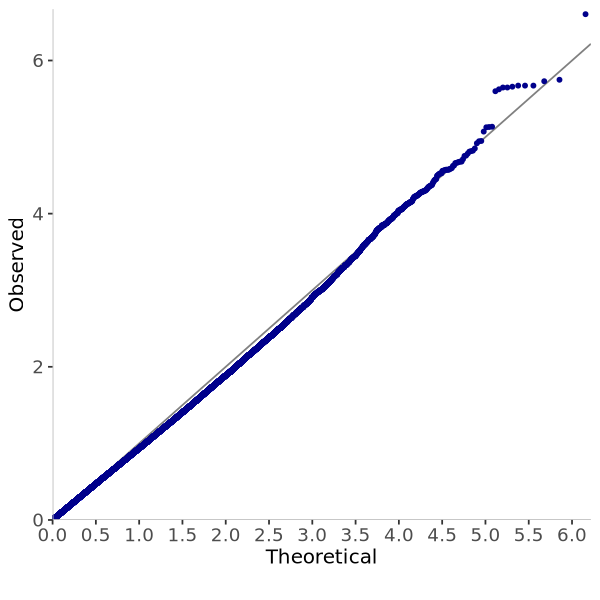

In [22]:
library(topr)

# set plot dimensions
options(repr.plot.width=5, repr.plot.height=5)

# qqplot
qqtopr(data)

We see that the points are mostly matching the theoretical null distribution, except at the top end, indicating that some SNPs may have statistically significant associations with the phenotype

In [24]:
get_lead_snps(data,thresh = 5e-06)

,CHROM,ID,POS,A1,A2,N,AF1,BETA,SE,P
,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
11,chr11,rs2851682,61616012,G,A,319,0.341693,-0.262948,0.0509703,2.48476e-07
12,chr12,kgp19064013,16142230,C,T,316,0.028481,0.760317,0.1591830,1.78484e-06
19,chr19,kgp8411531,45414399,A,C,319,0.112853,0.398667,0.0842982,2.25347e-06
8,chr8,kgp20327292,26221331,C,T,319,0.023511,0.809258,0.1719430,2.51944e-06


We'll do the region plot using the `regionplot` function
- `variant`: SNP id
- `annotate`: p-value threshold for annotation
- `build`: genome build to match SNPs (here we use 37)

In [25]:
data[which.min(data$P), ]


CHR,SNP,POS,A1,A2,N,AF1,BETA,SE,P
<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
11,rs2851682,61616012,G,A,319,0.341693,-0.262948,0.0509703,2.48476e-07


[1] "There are no SNPs with p-values below 5e-06 in the input dataset. Use the [thresh] argument to lower the threshold."
[1] "Zoomed to region:  6:153898759-154398759"


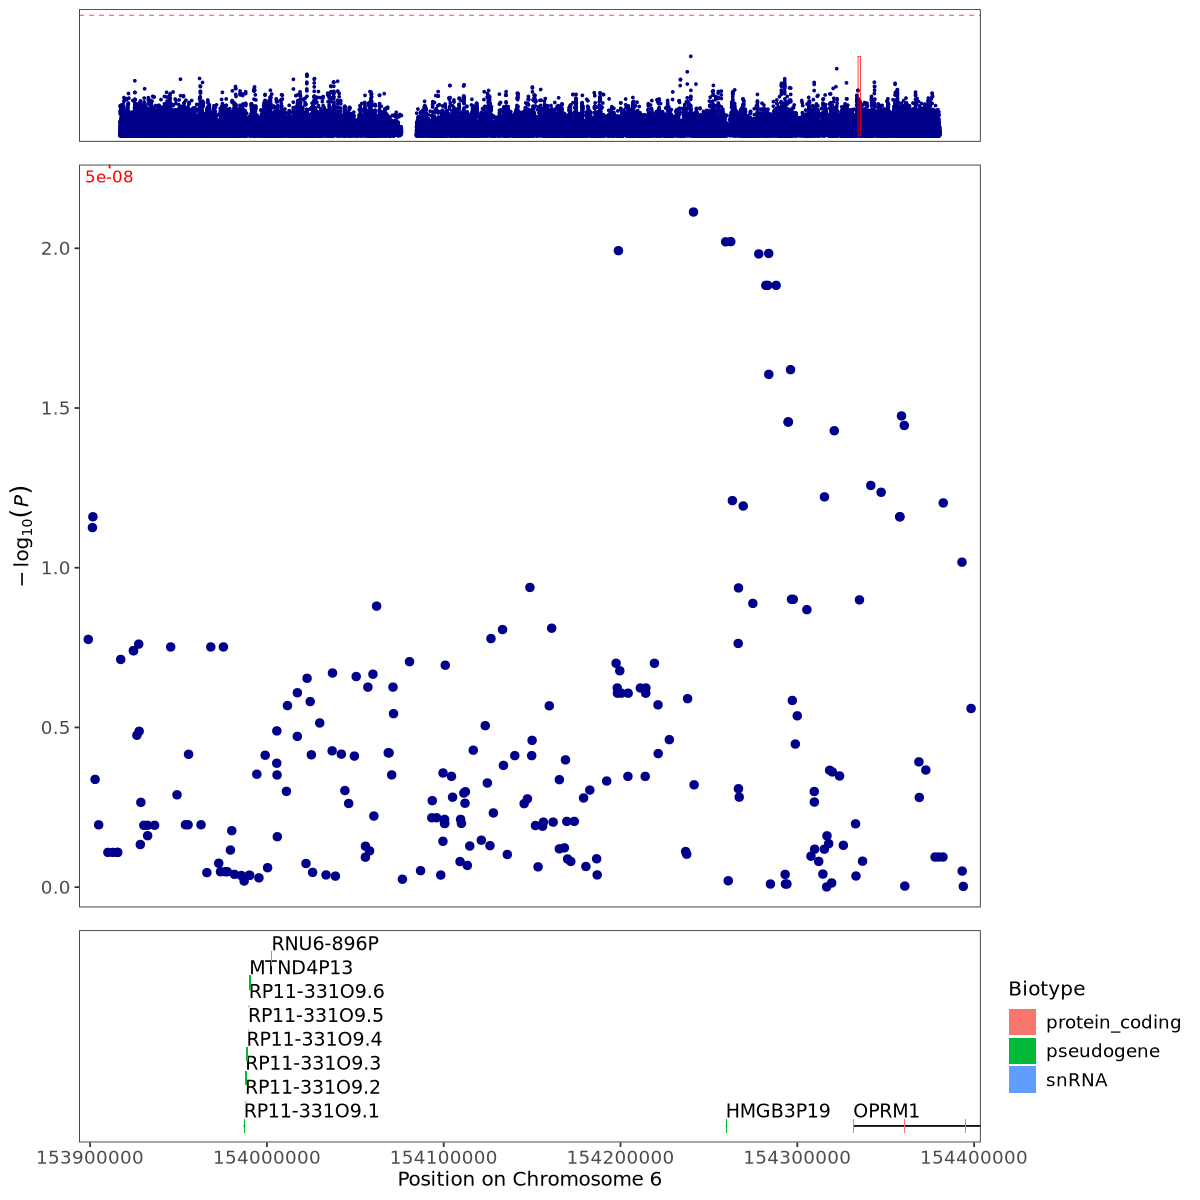

In [26]:
options(repr.plot.width=10, repr.plot.height=10)

regionplot(data,variant = "kgp3016912", annotate=5e-06, build=37)

**Regional plot by gene**

We can also do a regional plot by referencing a gene of interest. In this case, we'll look at `LDLRAD3` which was one of the candidate genes in the Manhattan plot

We'll do the region plot using the `regionplot` function
- `gene`: gene name (`LDLRAD3`)
- `annotate`: p-value threshold for annotation
- `build`: genome build to match SNPs (here we use 37)


[1] "There are no SNPs with p-values below 5e-06 in the input dataset. Use the [thresh] argument to lower the threshold."
[1] "Zoomed to region:  11:35865531-36353686"


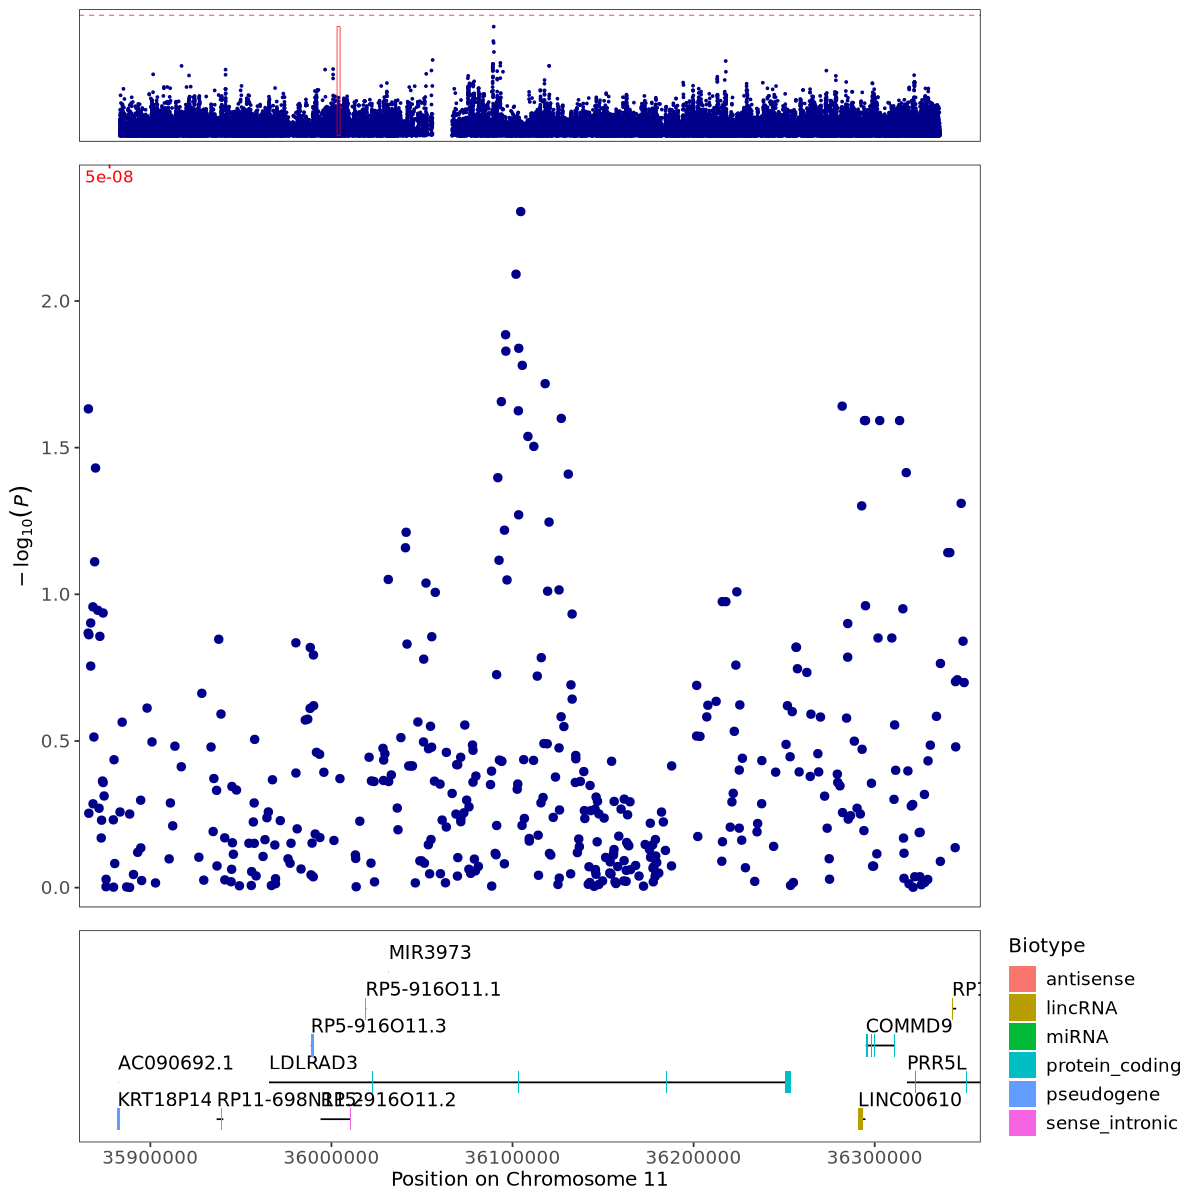

In [27]:
options(repr.plot.width=10, repr.plot.height=10)

regionplot(data,gene="LDLRAD3", annotate=5e-06, build=37)

The SNPs appear to fall in the region of the gene. We can explore the connections of this gene to related pathways using https://genemania.org

In [17]:
# full code by myself

library(tidyverse)
library(biomaRt)
library(CMplot)

# read file
res <- read_table2("gwas_TG_18_2_18_2_20_4.fastGWA")
names(res) <- tolower(names(res))   # chr, snp, pos, a1, a2, n, af1, beta, se, p

# find the min snp
lead <- res %>%
  filter(!is.na(p)) %>%
  slice_min(order_by = p, n = 1)
print(lead)

lead_chr <- lead$chr[1]
lead_bp  <- lead$pos[1]
lead_snp <- lead$snp[1]

# qq plot
observed <- -log10(sort(res$p))
expected <- -log10(ppoints(length(res$p)))
png("QQ_TG.png", width=1200, height=900, res=150)
plot(expected, observed,
     xlab="Expected -log10(P)",
     ylab="Observed -log10(P)",
     main="QQ plot: TG(18:2_18:2_20:4)",
     pch=20, cex=0.6)
abline(0,1,col="red")
dev.off()

# Manhattan
res_manhattan <- res %>%
  transmute(SNP = snp, Chromosome = as.integer(chr),
            Position = as.integer(pos), Pvalue = p)

CMplot(res_manhattan, plot.type="m", LOG10=TRUE,
       threshold=c(1e-5,5e-8), threshold.col=c("blue","red"),
       amplify=TRUE, signal.col=c("orange","red"),
       highlight=lead$snp,
       file="jpg", dpi=300,
       file.output=TRUE, width=10, height=6,
       out="Manhattan_TG")

# lead SNP is rsID
mart_snp <- useEnsembl(biomart="ENSEMBL_MART_SNP", dataset="hsapiens_snp")
snp_info <- tryCatch({
  getBM(attributes=c("refsnp_id","chr_name","chrom_start","chrom_end",
                     "ensembl_gene_stable_id","consequence_type_tv"),
        filters="snp_filter",
        values=lead_snp,
        mart=mart_snp)
}, error=function(e) data.frame())

# else chr:pos ±250bp
if(nrow(snp_info)==0) {
  mart_gene <- useEnsembl(biomart="ensembl", dataset="hsapiens_gene_ensembl")
  region <- paste0(lead_chr, ":", lead_bp-250, ":", lead_bp+250)
  snp_info <- getBM(attributes=c("chromosome_name","start_position","end_position",
                                 "ensembl_gene_id","hgnc_symbol"),
                    filters="chromosomal_region",
                    values=region,
                    mart=mart_gene)
}
print(snp_info)

# ±250kb
region_res <- res %>%
  filter(chr == lead_chr,
         pos >= (lead_bp - 250000),
         pos <= (lead_bp + 250000))

region_df <- region_res %>%
  transmute(SNP = snp, Chromosome = as.integer(chr),
            Position = as.integer(pos), Pvalue = p)

CMplot(region_df, plot.type="m", LOG10=TRUE,
       threshold=c(1e-5,5e-8), threshold.col=c("blue","red"),
       highlight=lead$snp,
       amplify=TRUE, signal.col=c("orange","red"),
       file="jpg", dpi=300,
       file.output=TRUE, width=8, height=6,
       out="RegionPlot_TG")



── Column specification ────────────────────────────────────────────────────────
cols(
  CHR = col_double(),
  SNP = col_character(),
  POS = col_double(),
  A1 = col_character(),
  A2 = col_character(),
  N = col_double(),
  AF1 = col_double(),
  BETA = col_double(),
  SE = col_double(),
  P = col_double()
)



# A tibble: 1 × 10
    chr snp            pos a1    a2        n   af1   beta     se           p
  <dbl> <chr>        <dbl> <chr> <chr> <dbl> <dbl>  <dbl>  <dbl>       <dbl>
1    11 rs2851682 61616012 G     A       319 0.342 -0.263 0.0510 0.000000248


agg_record_724960161 
                   2

 Rectangular Manhattan plotting Pvalue.
 Plots are stored in: /home/user/jupyterlab/phm5003/notebooks/06 - GWAS and PRS 
  refsnp_id chr_name chrom_start chrom_end ensembl_gene_stable_id
1 rs2851682       11    61848540  61848540        ENSG00000134824
  consequence_type_tv
1      intron_variant
 Rectangular Manhattan plotting Pvalue.
 Plots are stored in: /home/user/jupyterlab/phm5003/notebooks/06 - GWAS and PRS 
